In [4]:
%cd /Users/nicola/Desktop/sigoptim/kernel_hedge

import sigkernel
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as scipy
from scipy.stats import norm
from src.utils import augment_with_time

from src.kernel_compute import KernelCompute
from src.kernel_hedger_lean import KernelHedger
from src.kernel_trader_lean import KernelTrader

if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

%matplotlib inline

/Users/nicola/Desktop/sigoptim/kernel_hedge
device: cpu


# Hedging

## Preliminaries

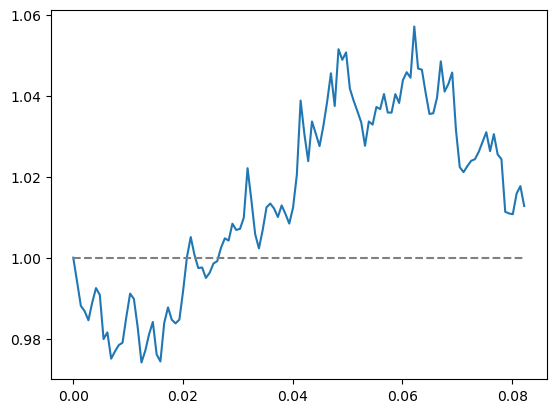

In [5]:
torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 500, 500, 120, 1
sigma, strike, S0, T = 0.2, 1.0, 1.0, 30./365 # Black Scholes parameters


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW.cumsum(dim=1)), dim = 1)
S = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

# train_paths = S[:batch_x]
test_paths = S[batch_x:]

batch_x = 200
train_paths = S[:batch_x]

plt.plot(torch.linspace(0.0, T, timesteps), S[0].detach().cpu())
plt.plot(torch.linspace(0.0, T, timesteps), strike*torch.ones(timesteps), '--', color = 'grey')
plt.show()

In [6]:
#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))


strike_K = strike
def EuropeanCall(S):
  S = S.cpu()
  temp_fn = np.vectorize(lambda x : torch.max(torch.tensor([x - strike_K, 0.0])))
  return torch.tensor(temp_fn(S[:, -1, :])).to(device)


def delta_hedge(ttm, strike, sigma, r, curr_price):
  temp = torch.log(curr_price.cpu()/strike) + (r + 0.5*sigma**2)*ttm
  temp = temp/(sigma*np.sqrt(ttm))
  return  torch.tensor(norm.cdf(temp)).to(device)

priceBS = BS(S0, strike, T, sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

delta_hedge_ = torch.zeros(test_paths[:,:,0].shape).to(device)
for j in range(test_paths.shape[0]):
    for i in range(test_paths.shape[1]):
        ttm = T - i*T/timesteps
        delta_hedge_[j, i] = delta_hedge(ttm, strike, sigma, 0.0, test_paths[j,i,0])

Price of a Call option in the Black scholes model with initial price 1.0 strike 1.0 maturity 0.0821917808219178 and volatility 0.2 is equal to 0.02287150628044965


In [7]:
def plot_results(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    kernel_Phi = kernel_hedge.Phi[0, test_index].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 2, 1)
    plt.plot(kernel_position, label='kernel')
    #plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kernel_Phi, label='Phi')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kernel_position, label='kernel')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()
    
def plot_results_old(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    kernel_Phi = kernel_hedge.Phi[test_index, 0].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 2, 1)
    plt.plot(kernel_position, label='kernel')
    #plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kernel_Phi, label='Phi')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kernel_position, label='kernel')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()
    
def plot_results_zoom(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 1, 1)
    plt.plot(kernel_position, label='kernel')
    plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()

## Body

In [8]:
class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = 2
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(self.scale*X.double(),self.scale*Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order]
    
    def K_Phi(self, X, time_augmented=False, max_batch=50):
        return super().K_Phi(X, time_augmented, max_batch)

In [9]:
Ker = SigKer()
X, Y = augment_with_time(train_paths), augment_with_time(test_paths)

# Phi = Ker.Phi(X, Y, time_augmented=True)
# K_Phi = Ker.K_Phi(X, time_augmented=True)

sk_hedge = KernelHedger(Ker,
                        EuropeanCall, priceBS, 
                        device, time_augment=True)

sk_hedge.pre_fit(train_paths)

Difference: tensor(0.0248, dtype=torch.float64)


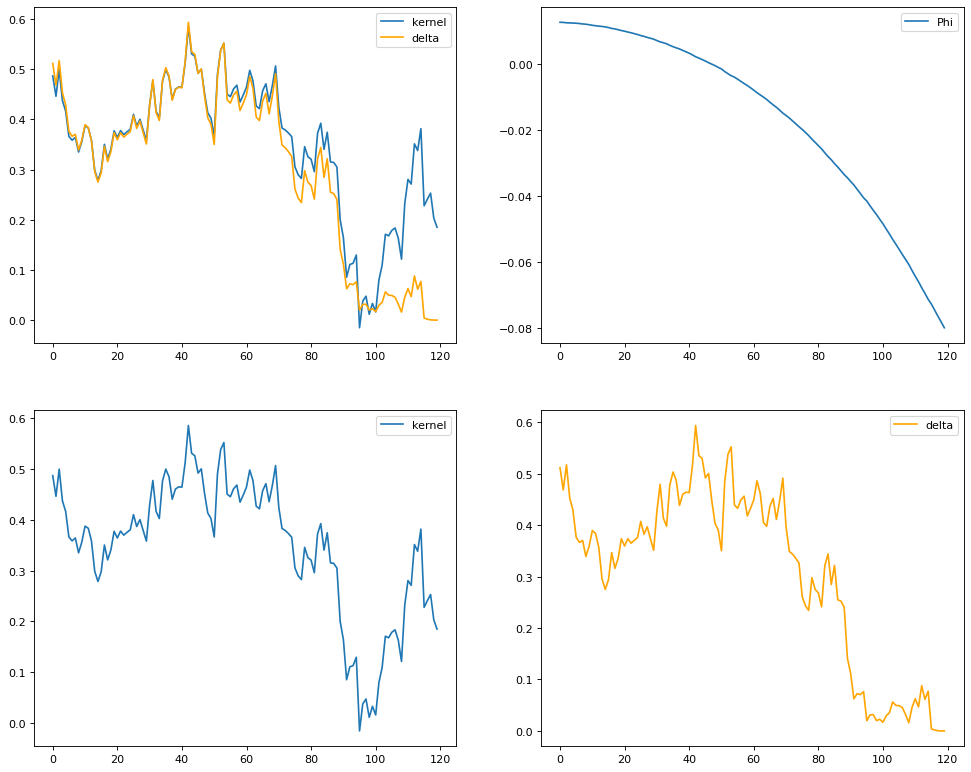

In [10]:
sk_hedge.fit(regularisation=4e-8*sk_hedge.Xi.norm())
sk_hedge.compute_pnl(test_paths)

plot_results(2, sk_hedge, delta_hedge_)

In [15]:
(sk_hedge.position.squeeze(-1) - delta_hedge_).norm(dim=-1).mean()

tensor(0.8114, dtype=torch.float64)

In [16]:
def print_loss_and_comparison(hedge_pnl, delta_pnl):
    
    # Compute losses
    sqrt_loss = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS  + hedge_pnl[:,-1].detach().cpu()))
    sqrt_loss_delta = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS + delta_pnl[:,-1]))
    loss = (sqrt_loss**2).mean()

    print('Expected OOS Loss: %s' % float(loss))
    print('Mean sqrtLoss: %s' % float(sqrt_loss.mean()))
    
    # Comparison Plot
    plt.hist(sqrt_loss, density=True, bins=20, label='kernel')
    plt.hist(sqrt_loss_delta, density=True, bins=20, label='delta')  

    plt.ylabel('Probability')
    plt.xlabel('Z - pi_0 - (H.S)_T')

    plt.legend()
    plt.show()

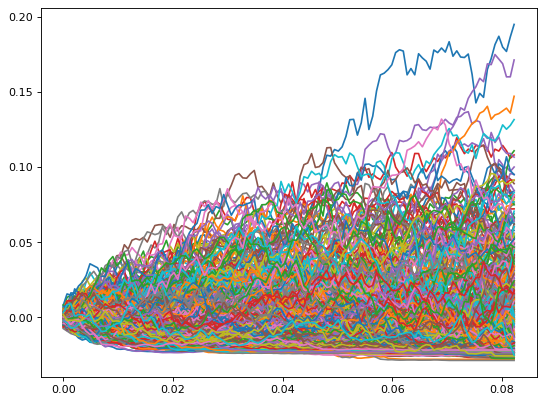

In [17]:
delta_hedge_all = torch.zeros((batch_y, timesteps))

for i in range(batch_y):
  delta_hedge_i = torch.zeros(timesteps-1)
  for t in range(timesteps-1):
    ttm = T - t*T/timesteps
    delta_hedge_i[t] = delta_hedge(ttm, strike, sigma, 0.0, test_paths[i,t,0])

  delta_hedge_all[i, 1:] = (test_paths[i].squeeze(-1).diff().cpu()*delta_hedge_i).cumsum(dim=0)



figure(figsize=(8, 6), dpi=80)
for i in range(batch_y):
  plt.plot(torch.linspace(0.0, T, timesteps-1), delta_hedge_all[i][1:])

In [18]:
sqrt_loss_delta = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS + delta_hedge_all[:,-1]))
loss_delta = (sqrt_loss_delta**2).mean()

print('Expected OOS Delta_Loss: %s' % float(loss_delta))
print('Mean Delta_sqrtLoss: %s' % float(sqrt_loss_delta.mean()))     

Expected OOS Delta_Loss: 3.3037343707275676e-06
Mean Delta_sqrtLoss: 1.0873427614569665e-05


Expected OOS Loss: 2.24855194580263e-05
Mean sqrtLoss: 0.00014171667164532593


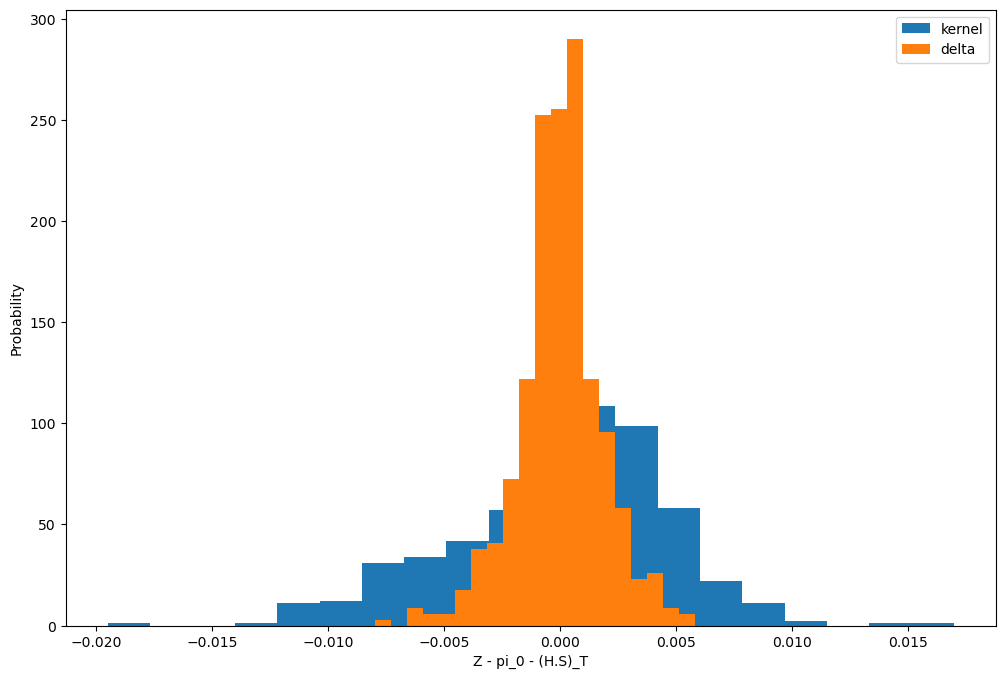

In [82]:
print_loss_and_comparison(sk_hedge.pnl, delta_hedge_all)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Expected OOS Loss: 2.24855194580263e-05
Mean sqrtLoss: 0.00014171667164532593


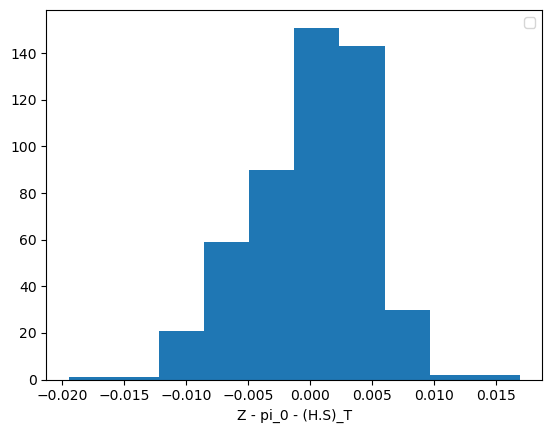

In [20]:
hedge_pnl = sk_hedge.pnl

# Compute losses
sqrt_loss = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS  + hedge_pnl[:,-1].detach().cpu()))
loss = (sqrt_loss**2).mean()

print('Expected OOS Loss: %s' % float(loss))
print('Mean sqrtLoss: %s' % float(sqrt_loss.mean()))

# Comparison Plot
plt.hist(sqrt_loss)

#plt.ylabel('Probability')
plt.xlabel('Z - pi_0 - (H.S)_T')

plt.legend()
plt.show()

tensor(0.0001, dtype=torch.float64)
tensor(0.0047, dtype=torch.float64)


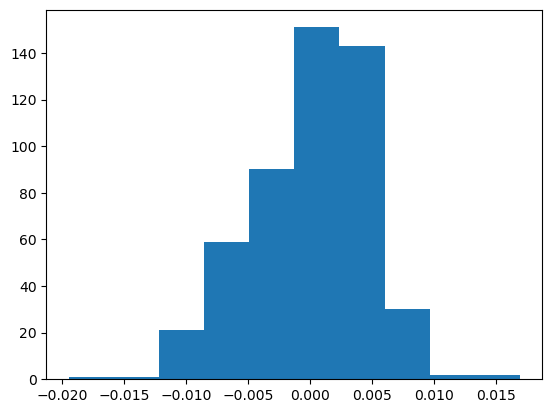

In [21]:
plt.hist(sqrt_loss)
print(sqrt_loss.mean())
print(sqrt_loss.std())

In [22]:
import pandas as pd

(sk_hedge.position.squeeze(-1) - delta_hedge_).norm(dim=-1).mean()

def to_csv(data, name):
    pd.DataFrame(data.numpy()).to_csv(name,index=False)

to_csv(sk_hedge.position.squeeze(-1), "hedge_position_"+str(batch_x))
to_csv(delta_hedge_, "delta_hedge_"+str(batch_x))
to_csv(sk_hedge.pnl, "hedge_pnl_"+str(batch_x))
to_csv(delta_hedge_all, "delta_pnl_"+str(batch_x))

In [32]:
def to_torch(file_name):
    return torch.from_numpy(pd.read_csv(file_name).to_numpy())

In [39]:
batches = [10, 50, 100, 200]

hedge_pnl = torch.zeros(len(batches), 500, 119)
hedge_positions = torch.zeros(len(batches), 500, 120)
delta_hedge = torch.zeros(len(batches), 500, 120)
delta_pnl = torch.zeros(len(batches), 500, 120)

for i in range(len(batches)):
    hedge_pnl[i] = to_torch("/Users/nicola/Desktop/sigoptim/kernel_hedge/CSVs/hedge_pnl_"+str(batches[i]))
    hedge_positions[i] = to_torch("/Users/nicola/Desktop/sigoptim/kernel_hedge/CSVs/hedge_position_"+str(batches[i]))
    delta_hedge[i] = to_torch("/Users/nicola/Desktop/sigoptim/kernel_hedge/CSVs/delta_hedge_"+str(batches[i]))
    delta_pnl[i] = to_torch("/Users/nicola/Desktop/sigoptim/kernel_hedge/CSVs/delta_pnl_"+str(batches[i]))


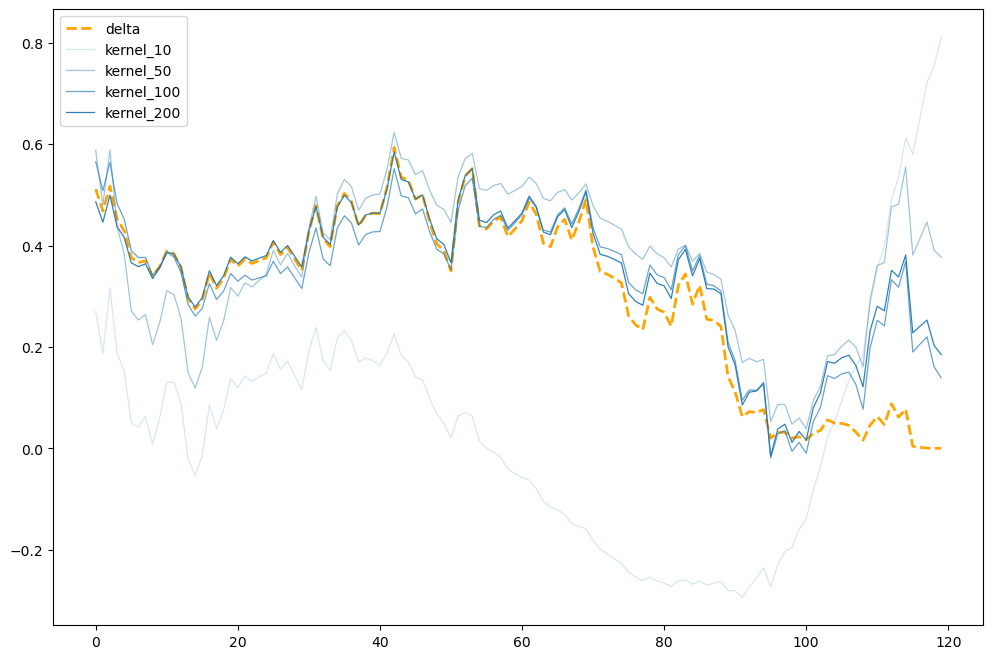

In [96]:
k = 2

plt.rcParams['figure.figsize'] = [12, 8]

plt.plot(delta_hedge[0, k], label="delta", color="orange", linestyle='--', lw=2)
for i in range(len(batches)):
    plt.plot(hedge_positions[i, k], label="kernel_"+str(batches[i]), color='C0', alpha=(i+.7)/4, lw=.9)
plt.legend()

Text(0, 0.5, 'Average L^2 Error')

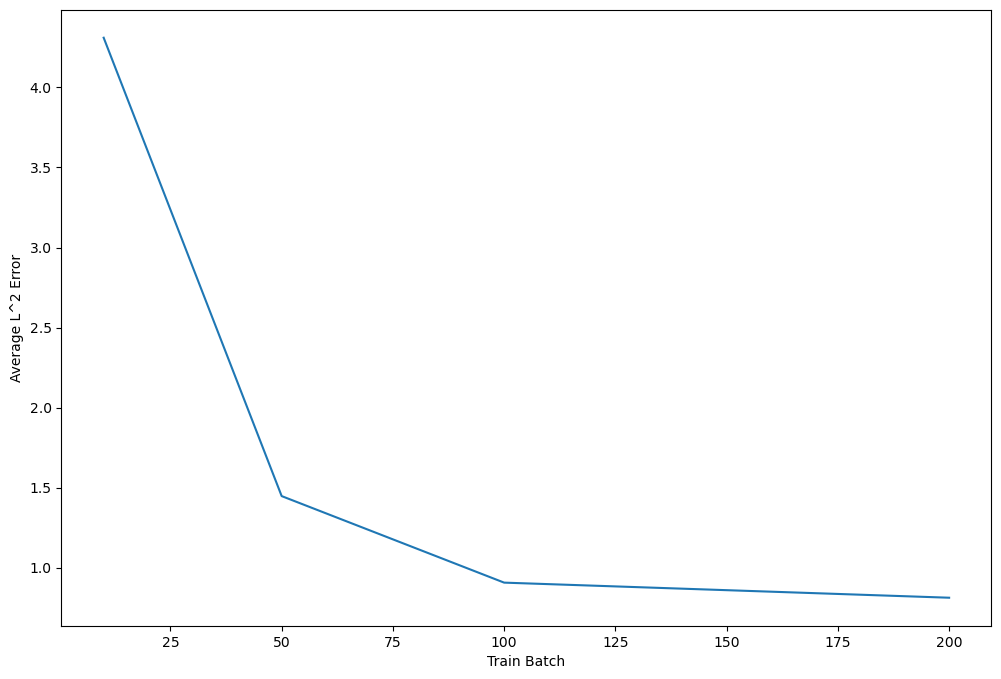

In [94]:
norms = [(hedge_positions[i] - delta_hedge[0]).norm(dim=-1).mean() for i in range(len(batches))]

plt.plot((batches), (norms), color='C0')
plt.xlabel("Train Batch")
plt.ylabel("Average L^2 Error")

In [66]:
sqrt_losses = [(EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS  + hedge_pnl[i][:,-1].detach().cpu())) for i in range(len(batches))]
sqrt_loss_delta = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS + delta_pnl[0][:,-1]))
loss = [(sqrt_losses[i]**2).mean() for i in range(len(batches))]

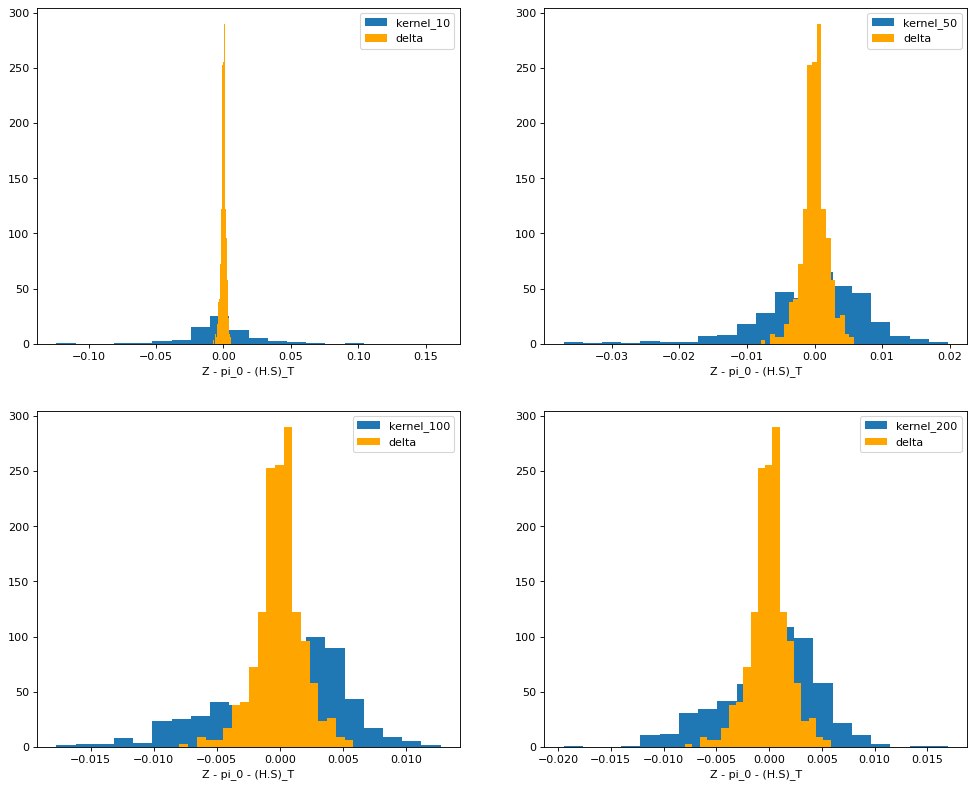

In [95]:
# Compute losses

figure(figsize=(15, 12), dpi=80)

sqrt_loss = [(EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS  + hedge_pnl[i][:,-1].detach().cpu())) for i in range(len(batches))]
sqrt_loss_delta = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS + delta_pnl[0][:,-1]))
loss = [(sqrt_loss[i]**2).mean() for i in range(len(batches))]
    
plt.subplot(2, 2, 1)
# Comparison Plot
i = 0
plt.hist(sqrt_loss[i], density=True, bins=20, label='kernel_'+str(batches[i]), color='C0')
plt.hist(sqrt_loss_delta, density=True, bins=20, label='delta', color='orange')  
#plt.ylabel('Probability')
plt.xlabel('Z - pi_0 - (H.S)_T')
plt.legend()

plt.subplot(2, 2, 2)
# Comparison Plot
i = 1
plt.hist(sqrt_loss[i], density=True, bins=20, label='kernel_'+str(batches[i]), color='C0')
plt.hist(sqrt_loss_delta, density=True, bins=20, label='delta', color='orange')  
#plt.ylabel('Probability')
plt.xlabel('Z - pi_0 - (H.S)_T')
plt.legend()

plt.subplot(2, 2, 3)
# Comparison Plot
i = 2
plt.hist(sqrt_loss[i], density=True, bins=20, label='kernel_'+str(batches[i]), color='C0')
plt.hist(sqrt_loss_delta, density=True, bins=20, label='delta', color='orange')
#plt.ylabel('Probability')
plt.xlabel('Z - pi_0 - (H.S)_T')
plt.legend()

plt.subplot(2, 2, 4)
# Comparison Plot
i = 3
plt.hist(sqrt_loss[i], density=True, bins=20, label='kernel_'+str(batches[i]), color='C0')
plt.hist(sqrt_loss_delta, density=True, bins=20, label='delta', color='orange')  
#plt.ylabel('Probability')
plt.xlabel('Z - pi_0 - (H.S)_T')
plt.legend()

plt.show()

# Trading

## Preliminaries

### Data Creation

$$X_t = X_t$$
$$Y_t = X_t + Z_t$$

with $X_t$ a 0-drift GBM and Z a 0-mean OU process.


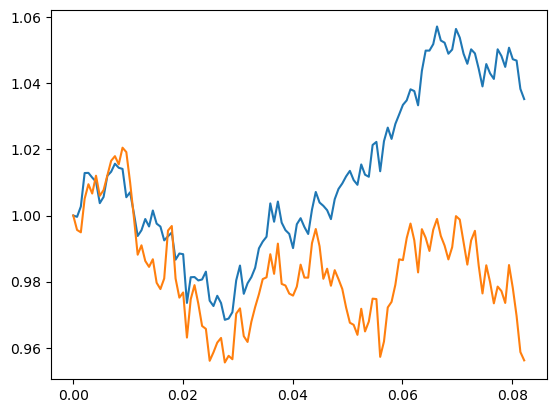

In [16]:
#torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 200, 100, 120, 1
sigma, S0, T = 0.2, 1.0, 30./365 # Black Scholes parameters
theta, mu, std = 4, 0.0, .15


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d, 2)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW[..., 0].cumsum(dim=1)), dim = 1)

X = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

Z = torch.zeros(X.shape).to(X.device.type)
for t in range(Z.shape[1]-1):
    Z[:, t+1, :] = Z[:, t, :] - theta*(mu - Z[:, t, :])*dt + std*dW[:, t, :, -1]


paths = torch.cat([X, X+Z], dim=-1)
train_paths = paths[:batch_x]
test_paths = paths[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), train_paths[0].detach().cpu())
plt.show()

## Body

In [17]:
class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = 2
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(self.scale*X.double(),self.scale*Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order]
    
    def K_Phi(self, X, time_augmented=False, max_batch=50):
        return super().K_Phi(X, time_augmented, max_batch)

In [18]:
Ker = SigKer()
sk_trade = KernelTrader(Ker,
                        device, time_augment=True)

sk_trade.pre_fit(train_paths)

In [19]:
sk_trade.fit(risk_aversion=0.5, regularisation=1e-5*sk_trade.Xi.norm())
sk_trade.compute_pnl(test_paths)

tensor(-0.0417, dtype=torch.float64)


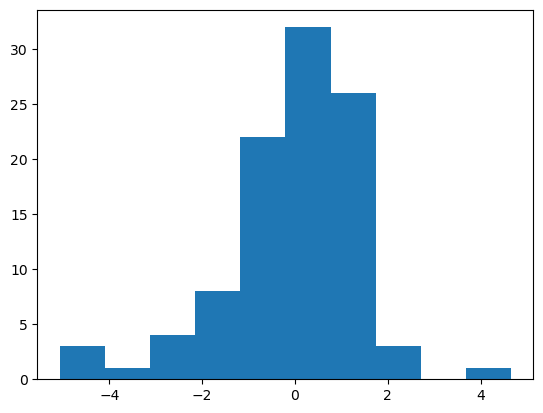

In [20]:
plt.hist(sk_trade.pnl[:,-1])
print(sk_trade.pnl[:,-1].mean())

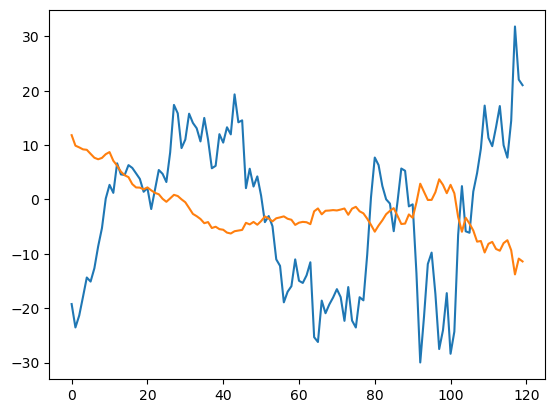

In [23]:
plt.plot(sk_trade.position[12])

In [30]:
a = 1
try:
    x = a / 0
except ValueError:
    x = 1
except ZeroDivisionError:
    x = 10
finally:
    x = 5
    
x

5